# Toxic Comment Classification Challenge

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

In [1]:
%matplotlib inline
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
subm_df = pd.read_csv('../input/sample_submission.csv')

In [ ]:
extra_df = pd.read_ts

## Looking at data

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


### quantities

In [6]:
print(len(train_df), "samples")

95851 samples


In [8]:
train_df[["toxic", "severe_toxic","obscene",
          "threat", "insult", "identity_hate"]].sum()

toxic            9237
severe_toxic      965
obscene          5109
threat            305
insult           4765
identity_hate     814
dtype: int64

In [14]:
len(train_df.dropna())

95851

### lengths of comments

The length of the comments varies:

In [10]:
lens = train_df.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.34186393464859, 595.10207169971216, 5000)

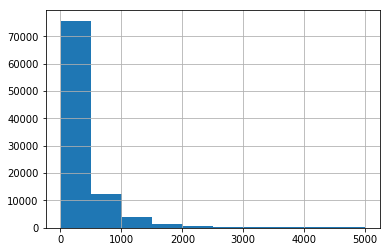

In [12]:
lens.hist();

In [13]:
len(train_df),len(test_df)

(95851, 226998)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [15]:
train_df['comment_text'].fillna("unknown", inplace=True)
test_df['comment_text'].fillna("unknown", inplace=True)

### comments examples

In [20]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [38]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['none'] = 1-train_df[label_cols].max(axis=1)
train_df.describe()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,9.585100e+04,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000
mean,4.994359e+11,0.096368,0.010068,0.053301,0.003182,0.049713,0.008492,0.897862
std,2.890136e+11,0.295097,0.099832,0.224635,0.056320,0.217352,0.091762,0.302831
min,2.225664e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473437e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.001297e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.501088e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999882e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
for cate in train_df.columns[2:]:
    print("====================")
    print(cate)
    print(train_df[train_df[cate] == 1].iloc[0].comment_text)
    print("====================")

toxic
Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated.
severe_toxic
F'UCK YOU ADMINISTRATORS (I WILL BE BACK TO TROLL YOU MORONS) 

Just a message.
obscene
"
Ban one side of an argument by a bullshit nazi admin and you get no discussion because the islamist editors feel they ""won""."
threat
"

 A knife for you! 

  A knife for you! One of this days, I am going to cut you into little pieces…   "
insult
"
Ban one side of an argument by a bullshit nazi admin and you get no discussion because the islamist editors feel they ""won""."
identity_hate
These Iranian bastards are at it again. Not only here, but also in the German Wikipedia. User:Tajik's German account, de:Benutzer:Phoenix2, is falsifying and misquoting sources. You need to watch his IPs! These Iranian faggots won't give up! Keep Rumi, Safavids, and Babak on your watchlist.


## Baseline model

We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [24]:
import re, string
re_tok = re.compile('([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [41]:
COMMENT = 'comment_text'
n = train_df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train_df[COMMENT])
test_term_doc = vec.transform(test_df[COMMENT])

This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

In [42]:
trn_term_doc, test_term_doc

(<95851x53127 sparse matrix of type '<class 'numpy.float64'>'
 	with 15641689 stored elements in Compressed Sparse Row format>,
 <226998x53127 sparse matrix of type '<class 'numpy.float64'>'
 	with 38036380 stored elements in Compressed Sparse Row format>)

### Basic Naive Bayes feature equation

In [43]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [44]:
x = trn_term_doc
test_x = test_term_doc

fit a model for one dependent at a time:

#### Cross-validation on training set

In [61]:
def get_mdl(x, y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(train_df), len(label_cols)))

from sklearn.model_selection import KFold
kf = KFold( n_splits=5, shuffle=True)

for train_index, val_index in kf.split(x):
    for i, j in enumerate(label_cols):
        print('fit', j)
        m,r = get_mdl(x[train_index], train_df.iloc[train_index][j])
        preds[val_index,i] = m.predict(x[val_index].multiply(r))

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [68]:
num_correct = 0

for row, row2 in zip(train_df[label_cols].values, preds):
    if all(row == row2):
        num_correct += 1
        

In [70]:
num_correct/len(train_df)

0.897820575685178

#### Train model on training set and predict for test set

In [45]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(test_df), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train_df[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


## Submission file

In [71]:
submid = pd.DataFrame({'id': subm_df["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

# Add model

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1).fit(training_features, training_labels)